<a href="https://colab.research.google.com/github/sled13/for_colab_nb/blob/main/Reputation_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

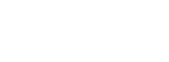

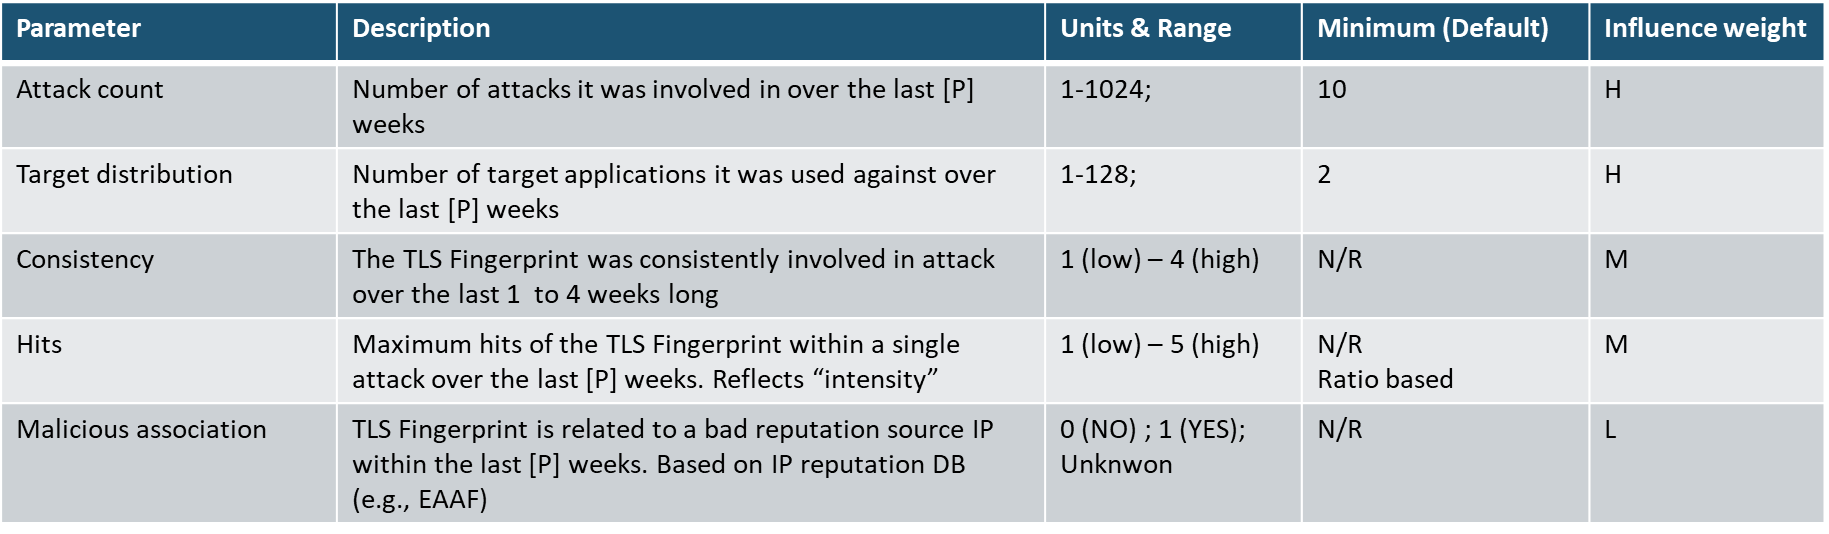

In [1]:
weight_h=1
weight_m=2/3
weight_l=1/3

attac_count_bounds=[1,1024]
attac_count_weight=weight_h

target_distribution_bounds=[1,128]
target_distribution_weight=weight_h

consistency_bounds=[1,4]
consistency_weight=weight_m

hits_bounds=[1,5]
hits_weight=weight_m

malicious_assosciation_bounds=[0,1]
malicious_assosciation_weight=weight_l

def restrict_to_bounds(value, value_bounds):
  if value<value_bounds[0]:
     value=value_bounds[0]
  if value>value_bounds[1]:
     value=value_bounds[1]
  return value

def normalized_value (value, value_bounds):
  return (value-value_bounds[0])/(value_bounds[1]-value_bounds[0])



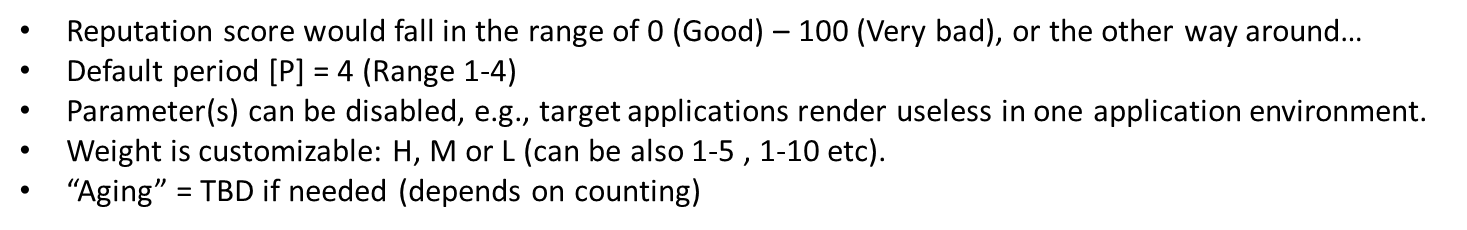

## Simple Average (SA) Heuristics approach: just wejgted average as score


In [2]:
def score_sa(attac_count,target_distribution,consistency,hits,malicious_assosciation):
  #restrict values
  attac_count=restrict_to_bounds(attac_count, attac_count_bounds)
  target_distribution=restrict_to_bounds(target_distribution, target_distribution_bounds)
  consistency=restrict_to_bounds(consistency, consistency_bounds)
  hits=restrict_to_bounds(hits, hits_bounds)
  malicious_assosciation=restrict_to_bounds(malicious_assosciation, malicious_assosciation_bounds)
  #---now all values are restricted
  #normalize values
  attac_count=normalized_value(attac_count, attac_count_bounds)
  target_distribution=normalized_value(target_distribution, target_distribution_bounds)
  consistency=normalized_value(consistency, consistency_bounds)
  hits=normalized_value(hits, hits_bounds)
  malicious_assosciation=normalized_value(malicious_assosciation, malicious_assosciation_bounds)
  #---now all values are normalized (on interval [0,1])

  # weighted sum calculation
  score=attac_count_weight*attac_count+\
  target_distribution_weight*target_distribution+\
  consistency_weight*consistency+\
  hits_weight*hits+\
  malicious_assosciation_weight*malicious_assosciation

  # weighted sum normalization
  score=100*score/(attac_count_weight+target_distribution_weight+consistency_weight+hits_weight+malicious_assosciation_weight)
  return score


## Testing score

In [3]:
import pandas as pd

steps_number=8 #it is a max of possible steps for each attribute
def step_for_bounds(value_bounds):
  value_step=(value_bounds[1]-value_bounds[0]+1)/steps_number
  if value_step<1:
    value_step=1
  return value_step

def test_score(score_=score_sa,file="score_sa.csv"):
  attac_count_step=step_for_bounds(attac_count_bounds)
  target_distribution_step=step_for_bounds( target_distribution_bounds)
  hits_step=step_for_bounds(hits_bounds)
  consistency_step=step_for_bounds(consistency_bounds)
  malicious_assosciation_step=step_for_bounds( malicious_assosciation_bounds)
  column1=[]
  column2=[]
  column3=[]
  column4=[]
  column5=[]
  column6=[]
  for i1 in range(steps_number+1):
    attac_count_i=attac_count_bounds[0]+i1*attac_count_step
    print(attac_count_i)
    if attac_count_i>attac_count_bounds[1] and attac_count_i<=attac_count_bounds[1]+1:
      attac_count_i=attac_count_bounds[1]
    if attac_count_i>attac_count_bounds[1]+1:break
    print(attac_count_i)
    for i2 in range(steps_number+1):
      target_distribution_i=target_distribution_bounds[0]+i2*target_distribution_step
      if target_distribution_i>target_distribution_bounds[1] and target_distribution_i<=target_distribution_bounds[1]+1:
          target_distribution_i=target_distribution_bounds[1]
      if target_distribution_i>target_distribution_bounds[1]+1:break
      for i3 in range(steps_number):
        consistency_i=consistency_bounds[0]+i3*consistency_step
        if consistency_i>consistency_bounds[1]:break
        for i4 in range(steps_number):
            hits_i=hits_bounds[0]+i4*hits_step
            if hits_i>hits_bounds[1]:break
            for i5 in range(steps_number):
              malicious_assosciation_i=malicious_assosciation_bounds[0]+i5*malicious_assosciation_step
              if malicious_assosciation_i>malicious_assosciation_bounds[1]:break

              value=round(score_(attac_count_i,target_distribution_i,consistency_i,hits_i,malicious_assosciation_i),ndigits=2)
              column1.append(attac_count_i)
              column2.append(target_distribution_i)
              column3.append(consistency_i)
              column4.append(hits_i)
              column5.append(malicious_assosciation_i)
              column6.append(value)
          #print(attac_count_i,target_distribution_i,consistency_i,malicious_assosciation_i,value)

  data = {'attac_count': column1, 'target_distribution': column2,'consistency':column3,'hits':column4,'malicious_assosciation':column5,"score":column6}
  df=pd.DataFrame.from_dict(data)
  df.index.name ='record'
  print(df)
  df.to_csv(file)
  return df

#testing default score (score_sa)
df_sa=test_score()

1.0
1.0
129.0
129.0
257.0
257.0
385.0
385.0
513.0
513.0
641.0
641.0
769.0
769.0
897.0
897.0
1025.0
1024
        attac_count  target_distribution  consistency  hits  \
record                                                        
0               1.0                  1.0            1     1   
1               1.0                  1.0            1     1   
2               1.0                  1.0            1     2   
3               1.0                  1.0            1     2   
4               1.0                  1.0            1     3   
...             ...                  ...          ...   ...   
3235         1024.0                128.0            4     3   
3236         1024.0                128.0            4     4   
3237         1024.0                128.0            4     4   
3238         1024.0                128.0            4     5   
3239         1024.0                128.0            4     5   

        malicious_assosciation   score  
record                             

## Probability Sum (PS) heuristics approach:
Based on formula p1&p2=p1+p2-p1*p2 or (which is the same) p1&p2=p1+p2*(1-p1) or (which is the same p1&p2=p2+p1*(1-p2)

In [4]:
def score_ps(attac_count,target_distribution,consistency,hits,malicious_assosciation):
  #restrict values
  attac_count=restrict_to_bounds(attac_count, attac_count_bounds)
  target_distribution=restrict_to_bounds(target_distribution, target_distribution_bounds)
  consistency=restrict_to_bounds(consistency, consistency_bounds)
  hits=restrict_to_bounds(hits, hits_bounds)
  malicious_assosciation=restrict_to_bounds(malicious_assosciation, malicious_assosciation_bounds)
  #---now all values are restricted
  #normalize values
  attac_count=normalized_value(attac_count, attac_count_bounds)
  target_distribution=normalized_value(target_distribution, target_distribution_bounds)
  consistency=normalized_value(consistency, consistency_bounds)
  hits=normalized_value(hits, hits_bounds)
  malicious_assosciation=normalized_value(malicious_assosciation, malicious_assosciation_bounds)
  #---now all values are normalized (on interval [0,1])

  # weighted probabilities sum calculation in recurent manner
  score=attac_count_weight*attac_count
  score=score+target_distribution_weight*target_distribution*(1-score)
  score=score+consistency_weight*consistency*(1-score)
  score=score+hits_weight*hits*(1-score)
  score=score+malicious_assosciation_weight*malicious_assosciation*(1-score)

  # score normalization
  score=100*score
  return score

  #testing default score (score_sa)
df_ps=test_score(score_=score_ps,file="score_ps.csv")

1.0
1.0
129.0
129.0
257.0
257.0
385.0
385.0
513.0
513.0
641.0
641.0
769.0
769.0
897.0
897.0
1025.0
1024
        attac_count  target_distribution  consistency  hits  \
record                                                        
0               1.0                  1.0            1     1   
1               1.0                  1.0            1     1   
2               1.0                  1.0            1     2   
3               1.0                  1.0            1     2   
4               1.0                  1.0            1     3   
...             ...                  ...          ...   ...   
3235         1024.0                128.0            4     3   
3236         1024.0                128.0            4     4   
3237         1024.0                128.0            4     4   
3238         1024.0                128.0            4     5   
3239         1024.0                128.0            4     5   

        malicious_assosciation   score  
record                             

## Combined table

In [5]:
df_combined=df_sa.rename(columns={"score":"score_sa"})
df_combined["score_ps"]=df_ps['score']
print(df_combined)
df_combined.to_csv("score_combined.csv")


        attac_count  target_distribution  consistency  hits  \
record                                                        
0               1.0                  1.0            1     1   
1               1.0                  1.0            1     1   
2               1.0                  1.0            1     2   
3               1.0                  1.0            1     2   
4               1.0                  1.0            1     3   
...             ...                  ...          ...   ...   
3235         1024.0                128.0            4     3   
3236         1024.0                128.0            4     4   
3237         1024.0                128.0            4     4   
3238         1024.0                128.0            4     5   
3239         1024.0                128.0            4     5   

        malicious_assosciation  score_sa  score_ps  
record                                              
0                            0      0.00      0.00  
1                    

## Description

In [6]:
pd_descr=df_combined.describe(percentiles=[0.25,0.75])
print(pd_descr)
pd_descr.to_csv("descr.csv")

       attac_count  target_distribution  consistency         hits  \
count  3240.000000          3240.000000  3240.000000  3240.000000   
mean    512.888889            64.888889     2.500000     3.000000   
std     330.373538            41.146880     1.118207     1.414432   
min       1.000000             1.000000     1.000000     1.000000   
25%     257.000000            33.000000     1.750000     2.000000   
50%     513.000000            65.000000     2.500000     3.000000   
75%     769.000000            97.000000     3.250000     4.000000   
max    1024.000000           128.000000     4.000000     5.000000   

       malicious_assosciation     score_sa     score_ps  
count             3240.000000  3240.000000  3240.000000  
mean                 0.500000    50.093898    90.804451  
std                  0.500077    16.235221    11.962427  
min                  0.000000     0.000000     0.000000  
25%                  0.000000    38.750000    87.527500  
50%                  0.500000 

## Random subset

In [7]:
import random
NN=df_sa.shape[0]
MM=30

selected_records_ids = random.sample(range(NN),MM)
selected_records_ids=set(selected_records_ids)
ind_list=list(selected_records_ids)
df_sa_random=df_sa.iloc[ind_list]
df_sa_random.to_csv("random.csv")